# Nav

![](https://imgs.xkcd.com/comics/coordinate_precision.png)

- [Adafruit_GPS](https://github.com/adafruit/Adafruit_GPS)

## Geocentric and Geodetic Latitudes

| | | |
|---|---|---|
| Geocentric Latitude | $\lambda$ | the angle subtended by the radius vector from the Earth center to the surface point with the equatorial plane |
| Geodetic Latitude   | $\mu$     | the angle subtended by the surface normal vector n and the equatorial plane |

$$
\begin{align}
\lambda_s &= \arctan((1-f)^2 \tan(\mu)) \\
r_s &= \sqrt {\frac {R^2} {1+(1/(1-f)^2-1) \sin^2 (\lambda_s)}} \\
P_{ECEF} &= \begin{bmatrix} p_x & p_y & p_z \end{bmatrix}^T \\
p_x &= r_s \cos(\lambda_s) \cos(i)+h \cos(\mu) \cos(i) \\
p_y &= r_s \cos(\lambda_s) \sin(i)+h \cos(\mu) \sin(i) \\
p_z &= r_s \sin(\lambda_s) + h \sin(\mu) 
\end{align}
$$


```python
def gps2ecef(lat, lon, H):
    # matlab: https://www.mathworks.com/help/aeroblks/llatoecefposition.html
    # this works, matches: https://www.oc.nps.edu/oc2902w/coord/llhxyz.htm
    mu = lat*pi/180
    i = lon*pi/180
    r = 6378137 # Radius of the planet at its equator in meters
    f = 1/298.257223563 # flattening
    ls = atan((1-f)**2 * tan(mu))
    rs = sqrt(r**2 / (1+ (1/(1-f)**2 - 1)*sin(ls)**2))

    x = rs*cos(ls)*cos(i) + H*cos(mu)*cos(i)
    y = rs*cos(ls)*sin(i) + H*cos(mu)*sin(i)
    z = rs*sin(ls)+H*sin(mu)

    return x,y,z
```

## Error Cov

- [ros answers][2]

- [swift navigation][3]

- `COVARIANCE_TYPE_APPROXIMATED = 1`: Another use case would be for when your receiver outputs [Dilution of Precision][1]. If you only get one value, as above, you would take the dilution of precision value (somewhere between 1 `ideal` and >20 `really bad`) and multiply this by the ideal measurement error.
- Example:
    - horizontal measurement error: 1.5m
    - HDOP: 2.3
    - standard dev: 1.5m * 2.3 = 3.45m
    - variance: (3.45m^2) = 11.9m^2
    - do the same for vertical with VDOP



[1]: https://en.wikipedia.org/wiki/Dilution_of_precision_(navigation)
[2]: https://answers.ros.org/question/10310/calculate-navsatfix-covariance/
[3]: https://support.swiftnav.com/support/solutions/articles/44002097796-gnss-receiver-estimated-accuracy-tutorial

In [5]:
# reload library
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import numpy as np
from matplotlib import pyplot as plt
from messages import *
import pickle
import json
import gzip
from pprint import pprint
from nav import *
# from ins_nav import WGS84
from the_collector import Collector

In [7]:
%ls data/

2023-08-12T15:10:19_Dtest.gzip


In [8]:
# with gzip.open('data/2023-08-06T15:46:46Ddriving.json.gzip', 'rt', encoding="ascii") as fd:
#     file = json.load(fd)
fname = "data/2023-08-12T15:10:19_Dtest.gzip"
col = Collector()
file = col.read(fname)
info = file["info"]
raw_data = file["data"]

print("----------------------------------------")
pprint(info)
print("----------------------------------------")
print(f"Loaded {len(raw_data)} data points")

Loaded 502 data points from:
--> data/2023-08-12T15:10:19_Dtest.gzip
----------------------------------------
{'DPS390': {'units': ['C', 'Pa']},
 'LIS3MDL': {'cal': {'bias': [-13.15340002, 29.7714855, 0.0645215],
                     'diag': [0.96545537, 0.94936676, 0.967698]},
             'range': [-4, 4],
             'units': 'gauss'},
 'LSM6DSOX': {'accel': {'cal': [[1.00268927,
                                 -0.00056029,
                                 -0.00190925,
                                 -0.00492348],
                                [-0.00138898,
                                 0.99580818,
                                 -0.00227335,
                                 0.00503835],
                                [-0.01438271,
                                 0.00673172,
                                 0.9998954,
                                 -0.01364759]],
                        'range': [-4, 4],
                        'units': 'g'},
              'gyro': {'cal

In [9]:
print("----------------------------------------")
raw_data[-1]

----------------------------------------


[[0.013559596613049507, 0.018005894497036934, 1.0068079233169556],
 [0.008899490348994732, -0.02001994475722313, -0.005899704527109861],
 [-14.36250114440918, -27.482017517089844, -49.015159606933594],
 [0.9999327659606934, 0.011025710962712765, 1.2830905377589385e-16, -0.0],
 [0.0, 0.0, 0.0, 0.0, 0, 0, [0, 0, 0], [0, 0, 0]],
 27.917861938476562,
 103294.2265625,
 975928]

In [10]:
def to_msgs(json_data):
    msgdata = []
    for vals in json_data:
        a = vec_t(*vals[0])
        g = vec_t(*vals[1])
        m = vec_t(*vals[2])
        q = quat_t(*vals[3])
        gps = gps_t(
            vals[4][0],
            vals[4][1],
            vals[4][2],
            vals[4][3],
            vals[4][4],
            vals[4][5],
            date_t(*vals[4][6]),
            clock_time_t(*vals[4][7]),
        )
        t = vals[5]
        p = vals[6]
        ts = vals[7]
        msg = msg_t(a,g,m,q,gps,t,p,ts)
        msgdata.append(msg)
    return msgdata

data = to_msgs(raw_data)
print(data[-1])

msg_t(a=vec_t(x=0.013559596613049507, y=0.018005894497036934, z=1.0068079233169556), g=vec_t(x=0.008899490348994732, y=-0.02001994475722313, z=-0.005899704527109861), m=vec_t(x=-14.36250114440918, y=-27.482017517089844, z=-49.015159606933594), q=quat_t(w=0.9999327659606934, x=0.011025710962712765, y=1.2830905377589385e-16, z=-0.0), gps=gps_t(lat=0.0, lon=0.0, altitude=0.0, hdop=0.0, satellites=0, fix=0, date=date_t(year=0, month=0, day=0), time=clock_time_t(hour=0, minute=0, seconds=0)), temperature=27.917861938476562, pressure=103294.2265625, timestamp=975928)


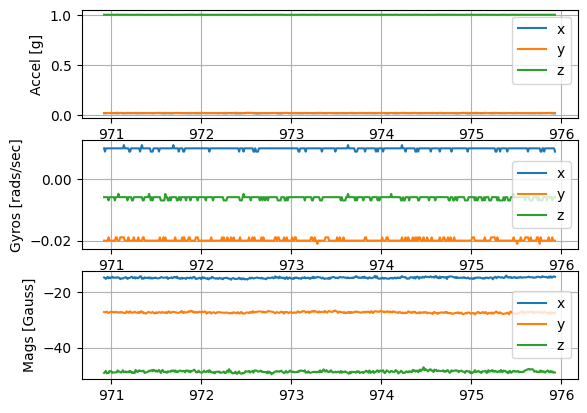

In [11]:
ts = [x.timestamp/1000 for x in data]

plt.subplot(311)
plt.plot(ts, [x.a.x for x in data], label="x")
plt.plot(ts, [x.a.y for x in data], label="y")
plt.plot(ts, [x.a.z for x in data], label="z")
plt.grid(True)
plt.ylabel(("Accel [g]"))
plt.legend();

plt.subplot(312)
plt.plot(ts, [x.g.x for x in data], label="x")
plt.plot(ts, [x.g.y for x in data], label="y")
plt.plot(ts, [x.g.z for x in data], label="z")
plt.grid(True)
plt.ylabel(("Gyros [rads/sec]"))
plt.legend();

plt.subplot(313)
plt.plot(ts, [x.m.x for x in data], label="x")
plt.plot(ts, [x.m.y for x in data], label="y")
plt.plot(ts, [x.m.z for x in data], label="z")
plt.grid(True)
plt.ylabel(("Mags [Gauss]"))
plt.legend();

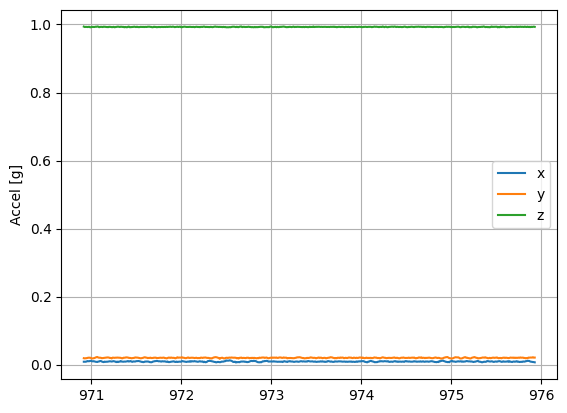

In [12]:
a = np.array([[x.a.x,x.a.y,x.a.z,1] for x in data])
acal = np.array(
  [[ 1.00268927, -0.00056029, -0.00190925, -0.00492348],
  [-0.00138898,  0.99580818, -0.00227335,  0.00503835],
  [-0.01438271,  0.00673172,  0.9998954 , -0.01364759]]
)

a = a @ acal.T
plt.plot(ts, a[:,0], label='x')
plt.plot(ts, a[:,1], label='y')
plt.plot(ts, a[:,2], label='z')
plt.grid(True)
plt.ylabel(("Accel [g]"))
plt.legend();

Text(0, 0.5, 'lat/lon [DD]')

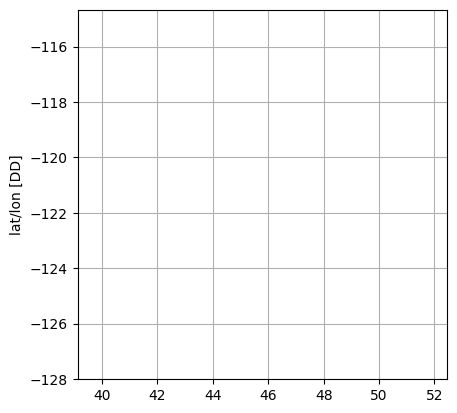

In [13]:
lat = [x.gps.lat for x in data if x.gps.fix == 1]
lon = [x.gps.lon for x in data if x.gps.fix == 1]
alt = [x.gps.altitude for x in data if x.gps.fix == 1]
sat = [x.gps.satellites for x in data if x.gps.fix == 1]
ecef = [gps2ecef(x.gps.lon, x.gps.lat, x.gps.altitude) for x in data if x.gps.fix == 1]
ecef = np.array(ecef)
ecef = ecef - ecef[0]

# plt.subplot(311)
plt.plot(lat, lon)
plt.axis('square')
plt.grid(True)
plt.ticklabel_format(style='plain')
plt.ylabel("lat/lon [DD]")

# plt.subplot(312)
# plt.plot(alt)
# plt.grid(True)
# plt.ylabel("Altitude [m]")

# plt.subplot(313)
# plt.plot(sat)
# plt.grid(True)
# plt.ylabel("Satellites");

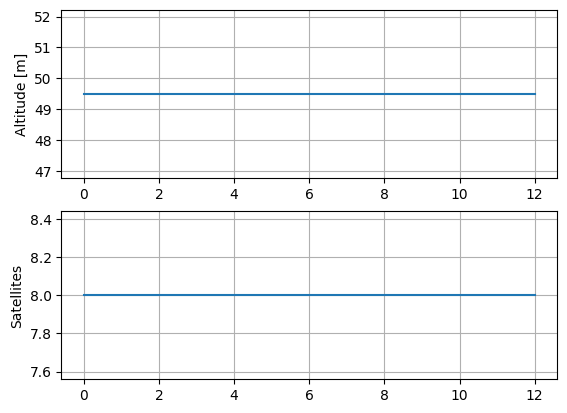

In [14]:
plt.subplot(211)
plt.plot(alt)
plt.grid(True)
plt.ylabel("Altitude [m]")

plt.subplot(212)
plt.plot(sat)
plt.grid(True)
plt.ylabel("Satellites");

In [15]:
ecef

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.13966666,  0.17178558,  0.        ],
       [-0.13966666,  0.17178558,  0.        ],
       [-0.27933334,  0.34357115,  0.        ],
       [-0.27933334,  0.34357115,  0.        ]])

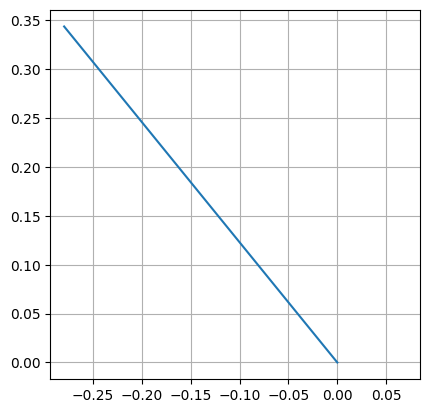

In [16]:
plt.plot(ecef[:,0],ecef[:,1])
plt.axis('square')
plt.grid(True);

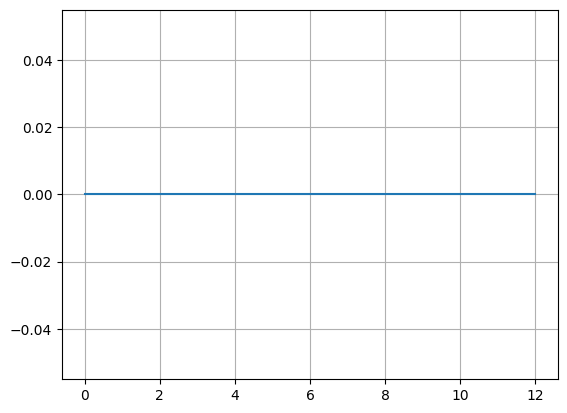

In [17]:
plt.plot(ecef[:,2])
plt.grid(True);

In [84]:
from pathlib import Path

In [144]:
p = Path("file.pkl")

In [145]:
p.name

'file.pkl'

In [96]:
str(p)

'data/here/file.pkl'

In [117]:
p.name

'file.pkl'

In [146]:
p.parent

PosixPath('.')

In [191]:
from collector import Collector

c = Collector()
d = [[1,2,3],[4,5,6]]
i = {"b":[1,2,3,4]}
c.write("test_test_now.csv",d,i,timestamp=False)
dd = c.read("test_test_now.csv")

Saving 2 data points in csv to:
--> test_test_now.csv


In [188]:
dd = c.read("test_test_now.csv")

Loaded 2 data points from:
--> test_test_now.csv


In [172]:
c.write("test_test_now.gzip",d,timestamp=False)

Saving 1 data points in json gzip to:
--> test_test_now.gzip


In [141]:
c = Collector()
dd = c.read("data/2023-08-07T20:44:08_test_test_now.gzip")

Loaded 6 data points from data/2023-08-07T20:44:08_test_test_now.gzip


In [162]:
dd = c.read("test_test_now.json")

Loaded 6 data points from:
--> test_test_now.json


In [186]:
%cat test_test_now.csv

1,2,3
4,5,6


In [193]:
d

[[1, 2, 3], [4, 5, 6]]

In [194]:
type(d)

list